In [13]:
from brian2 import *
# Parameters
simulation_duration = 6 * second

# Neurons
taum = 10*ms
# Ee is the extracellular potential
Ee = 0*mV
# Firing threshold is vt
vt = -54*mV
# Membrane potential is reset to vr
vr = -60*mV
# The rest potential is El
El = -74*mV
taue = 5*ms

# STDP
taupre = 20*ms
taupost = taupre
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApre *= gmax
dApost *= gmax

# Dopamine signaling
tauc = 1000*ms
taud = 200*ms
taus = 1*ms
epsilon_dopa = 5e-3

## Stimuli section
# Input current was added on 
input_indices = array([0,1,0,1,1,0,
                       0,1,0,1,1,0])
input_times = array([ 500,  550, 1000, 1010, 1500, 1510,
                     3500, 3550, 4000, 4010, 4500, 4510])*ms
input = SpikeGeneratorGroup(2,input_indices,input_times)
# The ge is the synaptic conductance
neurons = NeuronGroup(2,'''dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1''',threshold='v>vt',reset='v = vr',method='exact')
neurons.v = vr
neurons_monitor = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=[0,1])




synapse = Synapses(input,neurons,model='''s:volt''',on_pre='v += s')
# Connect neuron 0->0, 1->1
synapse.connect(i = [0,1],j = [0,1])

synapse.s = 100. *mV

## STDP section
# c is the important enzyme for synapse strength and d is the concentration of dopamine.
# We should understand that the c is influenced by STDP and has nothing to do with dopamine d.
# However the synapse strength s is influenced by both c and d.
synapse_stdp = Synapses(neurons,neurons,
                        model='''mode:1
                        dc/dt = -c / tauc :1 (clock-driven)
                        dd/dt = -d/taud :1 (clock-driven)
                        ds/dt = mode * c * d/taus :1 (clock-driven)
                        dApre/dt = -Apre / taupre :1 (event-driven)
                        dApost/dt = -Apost / taupost :1 (event-driven)''',
                        on_pre='''ge += s
                        Apre += dApre
                        c = clip(c + mode * Apost, -gmax, gmax)
                        s = clip(s + (1-mode) * Apre, -gmax , gmax)''',
                        on_post='''Apost += dApost
                        c = clip(c + mode * Apre, -gmax, gmax)
                        s = clip(s + (1-mode) * Apre, -gmax, gmax)''',
                        method='euler'
                        )
synapse_stdp.connect(i=0, j=1)
synapse_stdp.mode = 0
synapse_stdp.s = 1e-10
synapse_stdp.c = 1e-10
synapse_stdp.d = 0
synapse_stdp_monitor = StateMonitor(synapse_stdp,['s','c','d'],record = [0])

## Dopamine signaling section
dopamine_indices = array([0,0,0])
dopamine_times = array([3520,4020,4520]) * ms
dopamine = SpikeGeneratorGroup(1,dopamine_indices,dopamine_times)
dopamine_monitor = SpikeMonitor(dopamine)
reward = Synapses(dopamine,synapse_stdp,model = '''''',
                  on_pre = '''d_post += epsilon_dopa''',
                  method = 'exact')
reward.connect()

# Simulation
## Classical STDP
synapse_stdp.mode = 0
run(simulation_duration/2)
## Dopamine modulated STDP
synapse_stdp.mode = 1
run(simulation_duration/2)

print ('Finished')

Finished


([], <a list of 0 Text xticklabel objects>)

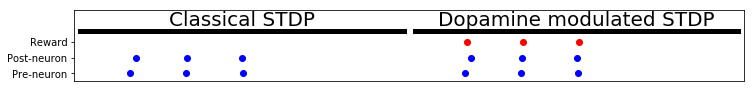

In [14]:
## Visualisation
dopamine_indices,dopamine_times = dopamine_monitor.it
neurons_indices, neurons_times = neurons_monitor.it
figure(figsize=(12,6))
subplot(411)
plot([0.05, 2.95], [2.7, 2.7], linewidth=5, color='k')
text(1.5, 3, 'Classical STDP', horizontalalignment='center', fontsize=20)
plot([3.05, 5.95], [2.7, 2.7], linewidth=5, color='k')
text(4.5, 3, 'Dopamine modulated STDP', horizontalalignment='center', fontsize=20)
plot(neurons_times, neurons_indices, 'ob')
plot(dopamine_times, dopamine_indices + 2, 'or')
xlim([0, simulation_duration/second])
ylim([-0.5, 4])
yticks([0, 1, 2], ['Pre-neuron', 'Post-neuron', 'Reward'])
xticks([])


([], <a list of 0 Text xticklabel objects>)

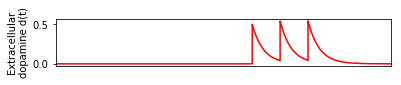

In [15]:
subplot(412)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.d.T/gmax, 'r-')
xlim([0, simulation_duration/second])
ylabel('Extracellular\ndopamine d(t)')
xticks([])

([], <a list of 0 Text xticklabel objects>)

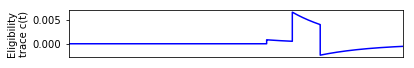

In [16]:
subplot(413)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.c.T/gmax, 'b-')
xlim([0, simulation_duration/second])
ylabel('Eligibility\ntrace c(t)')
xticks([])



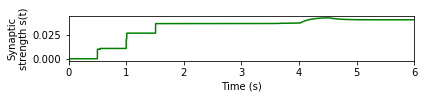

In [17]:
subplot(414)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.s.T/gmax, 'g-')
xlim([0, simulation_duration/second])
ylabel('Synaptic\nstrength s(t)')
xlabel('Time (s)')
tight_layout()
show()


[[-60.         -60.13930233 -60.27721857 ... -74.         -74.
  -74.        ]
 [-60.         -60.13930233 -60.27721857 ... -74.         -74.
  -74.        ]] mV


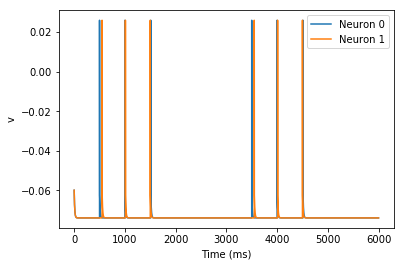

In [18]:
print(M.v)
plot(M.t/ms, M.v[0],label='Neuron 0')
xlabel('Time (ms)')
ylabel('v');

plot(M.t/ms, M.v[1],label='Neuron 1')
xlabel('Time (ms)')
ylabel('v');

legend()

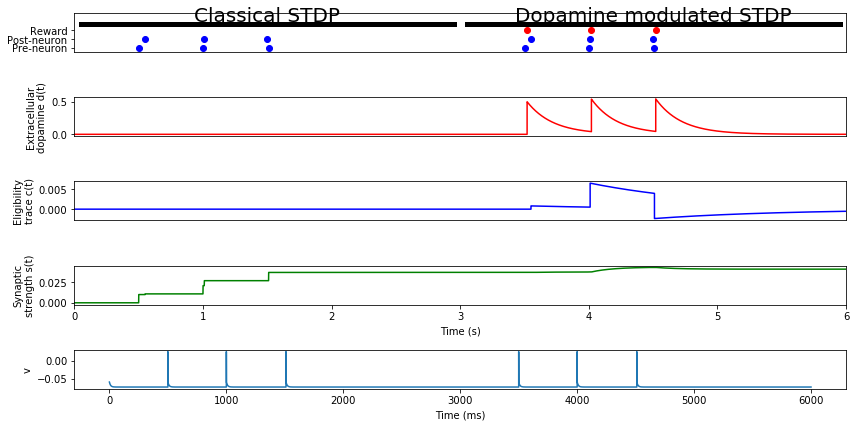

In [19]:
# All
# Visualisation
dopamine_indices, dopamine_times = dopamine_monitor.it
neurons_indices, neurons_times = neurons_monitor.it
figure(figsize=(12,6))
subplot(511)
plot([0.05, 2.95], [2.7, 2.7], linewidth=5, color='k')
text(1.5, 3, 'Classical STDP', horizontalalignment='center', fontsize=20)
plot([3.05, 5.95], [2.7, 2.7], linewidth=5, color='k')
text(4.5, 3, 'Dopamine modulated STDP', horizontalalignment='center', fontsize=20)
plot(neurons_times, neurons_indices, 'ob')
plot(dopamine_times, dopamine_indices + 2, 'or')
xlim([0, simulation_duration/second])
ylim([-0.5, 4])
yticks([0, 1, 2], ['Pre-neuron', 'Post-neuron', 'Reward'])
xticks([])
subplot(512)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.d.T/gmax, 'r-')
xlim([0, simulation_duration/second])
ylabel('Extracellular\ndopamine d(t)')
xticks([])
subplot(513)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.c.T/gmax, 'b-')
xlim([0, simulation_duration/second])
ylabel('Eligibility\ntrace c(t)')
xticks([])
subplot(514)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.s.T/gmax, 'g-')
xlim([0, simulation_duration/second])
ylabel('Synaptic\nstrength s(t)')
xlabel('Time (s)')
subplot(515)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');
tight_layout()
show()

